Epoch [100/1000], Loss: 0.5497
Epoch [200/1000], Loss: 0.3816
Epoch [300/1000], Loss: 0.2943
Epoch [400/1000], Loss: 0.2169
Epoch [500/1000], Loss: 0.1389
Epoch [600/1000], Loss: 0.0671
Epoch [700/1000], Loss: 0.0228
Epoch [800/1000], Loss: 0.0116
Epoch [900/1000], Loss: 0.0073
Epoch [1000/1000], Loss: 0.0050


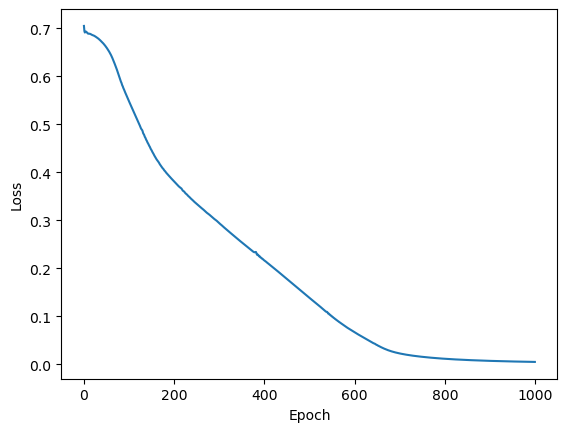

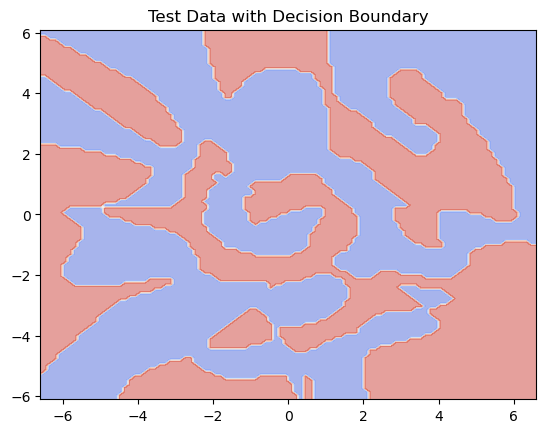

In [43]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Load the dataset
data = pd.read_csv('datasets/spiralsdataset.csv', header=None, names=['x1', 'x2', 'y'])

# Split the dataset into features and labels
X = data[['x1', 'x2']].to_numpy()
y = data['y'].to_numpy()

# Convert the labels to one-hot encoding
y = np.eye(2)[y]

# Split the dataset into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the training and test data to PyTorch tensors
x_train = torch.from_numpy(X_train).type(torch.float32)
x_test = torch.from_numpy(X_test).type(torch.float32)
y_train = torch.from_numpy(y_train).type(torch.float32)
y_test = torch.from_numpy(y_test).type(torch.float32)

# Define the FFNN architecture
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = nn.Sigmoid()(x)
        return x

# Set the hyperparameters
input_size = 2
hidden_size = 20
output_size = 2
learning_rate = 0.01
num_epochs = 1000

# Create the FFNN
net = Net(input_size,hidden_size,output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Train the FFNN
loss_list = []
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = net(x_train)
    loss = criterion(outputs, y_train)
    loss_list.append(loss.item())
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

# Plot the loss
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the FFNN
with torch.no_grad():
    outputs = net(x_test)
    predicted = torch.argmax(outputs, dim=1)

# Plot the dataset with the predicted classes
x1_min, x1_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
x2_min, x2_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
xx, yy = torch.meshgrid(torch.linspace(x1_min, x1_max, 100),
                         torch.linspace(x2_min, x2_max, 100))
X_grid = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)), dim=1)

# Get the predicted class labels for the grid points
with torch.no_grad():
    grid_outputs = net(X_grid)
    grid_predicted = torch.argmax(grid_outputs, dim=1)

# Plot the decision boundary
plt.contourf(xx, yy, grid_predicted.reshape(xx.shape), cmap='coolwarm', alpha=0.5)
# plt.scatter(X[:, 0], X[:, 1], c=y.argmax(axis=1), cmap='coolwarm')
plt.title('Test Data with Decision Boundary')
plt.show()
